### Подключение библиотек

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

### Подключение к GPU

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Загрузка датасета с НОРМАЛИЗАЦИЕЙ 180. Формат X и Y

In [4]:
# Чтение датасета из файла, зарегистрированного кинект
test_df = pd.read_csv("test_data.txt", sep='\t', comment='#', encoding='utf-8')
# Сдвиг значений из индекса на колонку вперед
test_df = test_df.shift(periods=1, axis="columns")
test_df['HumFlex-L'] = test_df.index
test_df.index=[_ for _ in range(85400) ]
# Готовый Датасет
test_df

,HumFlex-L,HumFlex-R,HumAdd-L,HumAdd-R,HumPron-L,HumPron-R,CubFlex-L,CubFlex-R,CubPron-L,CubPron-R,RadFlex-L,RadFlex-R,RadAdd-L,RadAdd-R
0,25.3891,9.27357,8.17163,8.20268,6.54854,31.5294,131.409,12.6733,25.9416,-72.2202,12.4294,-0.131512,-37.7395,1.51097
1,25.3891,9.27357,8.17163,8.20268,6.54854,31.5294,131.409,12.6733,25.9416,-72.2202,12.4294,-0.131512,-37.7395,1.51097
2,25.3868,9.27080,8.17124,8.20132,6.54858,31.5304,131.410,12.6754,25.9413,-72.2209,12.4288,-0.131742,-37.7401,1.51067
3,25.3868,9.27080,8.17124,8.20132,6.54858,31.5304,131.410,12.6754,25.9413,-72.2209,12.4288,-0.131742,-37.7401,1.51067
4,25.3844,9.26813,8.17081,8.19961,6.54859,31.5316,131.411,12.6767,25.9409,-72.2216,12.4281,-0.131909,-37.7408,1.51038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85395,26.4817,8.81054,10.46340,10.15400,13.71280,44.9465,149.520,44.0545,31.3010,-80.1557,10.8189,1.841450,-51.1252,1.24794
85396,26.4827,8.81207,10.46390,10.15460,13.71320,44.9472,149.519,44.0548,31.3012,-80.1564,10.8193,1.841770,-51.1252,1.24859
85397,26.4827,8.81207,10.46390,10.15460,13.71320,44.9472,149.519,44.0548,31.3012,-80.1564,10.8193,1.841770,-51.1252,1.24859
85398,26.4837,8.81374,10.46450,10.15540,13.71340,44.9475,149.519,44.0552,31.3014,-80.1570,10.8199,1.841800,-51.1252,1.24873


In [5]:
# Перемещение 4х прогнозируемых колонок вперед (локтевой сустав)
# Обозначения:
# L / R - левая и правая рука
# CubFlex / CubPron- локтевое сгибание / пронация
# HumFlex / HumPron / HumAdd - плечевое сгибание / пронация / приведение
# RadFlex / RadAdd - лучезапястное сгибание / приведение
tmp_test_df = pd.DataFrame({
                            'CubFlex-L': test_df['CubFlex-L'] / 180, 'CubFlex-R': test_df['CubFlex-R'] / 180,
                            'CubPron-L': test_df['CubPron-L'] / 180, 'CubPron-R': test_df['CubPron-R'] / 180,
                            'HumFlex-L': test_df['HumFlex-L'] / 180, 'HumFlex-R': test_df['HumFlex-R'] / 180,
                            'HumPron-L': test_df['HumPron-L'] / 180, 'HumPron-R': test_df['HumPron-R'] / 180,
                            'HumAdd-L': test_df['HumAdd-L'] / 180, 'HumAdd-R': test_df['HumAdd-R'] / 180,
                            'RadFlex-L': test_df['RadFlex-L'] / 180, 'RadFlex-R': test_df['RadFlex-R'] / 180,
                            'RadAdd-L': test_df['RadAdd-L'] / 180, 'RadAdd-R': test_df['RadAdd-R'] / 180,
                             })

output_df = tmp_test_df.loc[:, 'CubFlex-L' : 'CubPron-R']
input_df = tmp_test_df.loc[:, 'HumFlex-L' : 'RadAdd-R']
# Нормализованный датасет
tmp_test_df

,CubFlex-L,CubFlex-R,CubPron-L,CubPron-R,HumFlex-L,HumFlex-R,HumPron-L,HumPron-R,HumAdd-L,HumAdd-R,RadFlex-L,RadFlex-R,RadAdd-L,RadAdd-R
0,0.730050,0.070407,0.144120,-0.401223,0.141051,0.051520,0.036381,0.175163,0.045398,0.045570,0.069052,-0.000731,-0.209664,0.008394
1,0.730050,0.070407,0.144120,-0.401223,0.141051,0.051520,0.036381,0.175163,0.045398,0.045570,0.069052,-0.000731,-0.209664,0.008394
2,0.730056,0.070419,0.144118,-0.401227,0.141038,0.051504,0.036381,0.175169,0.045396,0.045563,0.069049,-0.000732,-0.209667,0.008393
3,0.730056,0.070419,0.144118,-0.401227,0.141038,0.051504,0.036381,0.175169,0.045396,0.045563,0.069049,-0.000732,-0.209667,0.008393
4,0.730061,0.070426,0.144116,-0.401231,0.141024,0.051490,0.036381,0.175176,0.045393,0.045553,0.069045,-0.000733,-0.209671,0.008391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85395,0.830667,0.244747,0.173894,-0.445309,0.147121,0.048947,0.076182,0.249703,0.058130,0.056411,0.060105,0.010230,-0.284029,0.006933
85396,0.830661,0.244749,0.173896,-0.445313,0.147126,0.048956,0.076184,0.249707,0.058133,0.056414,0.060107,0.010232,-0.284029,0.006937
85397,0.830661,0.244749,0.173896,-0.445313,0.147126,0.048956,0.076184,0.249707,0.058133,0.056414,0.060107,0.010232,-0.284029,0.006937
85398,0.830661,0.244751,0.173897,-0.445317,0.147132,0.048965,0.076186,0.249708,0.058136,0.056419,0.060111,0.010232,-0.284029,0.006937


In [7]:
WINDOW_SIZE = 20
# Структура входных и выходных данных (для window_size=20)
# 0, 1, ... - индекс строки в df
# [0:3] - Срез по индексам прогнозируемых колонок
#        X - входные данные        |   y  - выходные данные             
# [                                | [
#   [[0], [1], [2], ..., [19]],    |  [20[0:3]]
#   [[1], [2], [3], ..., [20]],    |  [21[0:3]]
#   [[2], [3], [4], ..., [21]],    |  [22[0:3]]
#   ...                            |  ...
#   [[85379],[85380],...,[85398]], |  [85399[0:3]]
# ]                                | ]

def df_to_X(df, window_size = WINDOW_SIZE):
  df_as_np = df.to_numpy()
  X = []
  for i in range(len(df_as_np)-window_size):
    row = np.array([r for r in df_as_np[i:i+window_size]])

    if np.isnan(row).any():
      print(row)
      continue
    X.append(row)
  return np.array(X)

def df_to_y(df, window_size = WINDOW_SIZE):
  df_as_np = df.to_numpy()
  y = []
  for i in range(len(df_as_np)-window_size):
    label = []
    for j in range(len(output_df.axes[1])):
      label.append(df_as_np[i+window_size][j])
    y.append(label)
  return np.array(y)

In [8]:
X, y = df_to_X(tmp_test_df), df_to_y(output_df)
X.shape, y.shape

((85380, 20, 14), (85380, 4))

### Разбиение на training, validation and test dataset

In [9]:
def splitToTrainValTest(X, y):
    X_train, y_train = X[:55000], y[:55000] # Было :60-60:70-70: стало 80%()
    X_val, y_val = X[55000:75000], y[55000:75000]
    X_test, y_test = X[75000:], y[75000:]
    print("Train:\n\t{}\n\t{}\nValidation:\n\t{}\n\t{}\nTest:\n\t{}\n\t{}".format(X_train.shape,  y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = splitToTrainValTest(X, y)

Train:
	(55000, 20, 14)
	(55000, 4)
Validation:
	(20000, 20, 14)
	(20000, 4)
Test:
	(10380, 20, 14)
	(10380, 4)


### Отображение графиков результатов и расчет RMSE

In [11]:
def plot_predictions(predictions, actuals_y, start, end, isNormalized=False):
  CubFlexL_preds, CubFlexR_preds, CubPronL_preds, CubPronR_preds = predictions[:, 0], predictions[:, 1], predictions[:, 2], predictions[:, 3]
  CubFlexL_actuals, CubFlexR_actuals, CubPronL_actuals, CubPronR_actuals = actuals_y[:, 0], actuals_y[:, 1], actuals_y[:, 2], actuals_y[:, 3],
  df = pd.DataFrame(data={'CubFlex-L Predictions': CubFlexL_preds,
                          'CubFlex-L Actuals':CubFlexL_actuals,
                          'CubFlex-R Predictions': CubFlexR_preds,
                          'CubFlex-R Actuals':CubFlexR_actuals,
                          'CubPron-L Predictions': CubPronL_preds,
                          'CubPron-L Actuals':CubPronL_actuals,
                          'CubPron-R Predictions': CubPronR_preds,
                          'CubPron-R Actuals':CubPronR_actuals,
                          })
  fig = plt.figure(figsize=[12, 7])
  plt.subplot(2, 2, 1)
  plt.grid()
  plt.title('Локтевое сгибание-L')
  plt.xlabel('№ временного шага')
  if (isNormalized):
    plt.ylabel('Нормализованный суставной угол')
  else:
    plt.ylabel('Суставной угол в градусах')
  l1 = plt.plot(df['CubFlex-L Predictions'][start:end], 'r--')
  l2 = plt.plot(df['CubFlex-L Actuals'][start:end], 'green')

  plt.subplot(2, 2, 2)
  plt.grid()

  plt.title('Локтевое сгибание-R')
  plt.xlabel('№ временного шага')
  if (isNormalized):
    plt.ylabel('Нормализованный суставной угол')
  else:
    plt.ylabel('Суставной угол в градусах')
  plt.plot(df['CubFlex-R Predictions'][start:end], 'r--')
  plt.plot(df['CubFlex-R Actuals'][start:end], 'green')
  
  plt.subplot(2, 2, 3)
  plt.grid()
  plt.title('Локтевая пронация-L')
  plt.xlabel('№ временного шага')
  if (isNormalized):
    plt.ylabel('Нормализованный суставной угол')
  else:
    plt.ylabel('Суставной угол в градусах')
  plt.plot(df['CubPron-L Predictions'][start:end], 'r--')
  plt.plot(df['CubPron-L Actuals'][start:end], 'green')

  plt.subplot(2, 2, 4)
  plt.grid()
  plt.title('Локтевая пронация-R')
  plt.xlabel('№ временного шага')
  if (isNormalized):
    plt.ylabel('Нормализованный суставной угол')
  else:
    plt.ylabel('Суставной угол в градусах')
  plt.plot(df['CubPron-R Predictions'][start:end], 'r--',)
  plt.plot(df['CubPron-R Actuals'][start:end], 'green')

  plt.subplots_adjust( hspace=0.4)
  fig.legend([l1, l2], labels=['Прогнозируемые значения', 'Истинные значения'], loc="center")
  
  return df

In [12]:
def rmse(predictions, actuals):
    return np.sqrt(((predictions - actuals) ** 2).mean())

### Объявление функции Predict по нормализованным X_test

In [20]:
def get_normalized_predictions(model, X_normalized):
    normalized_predictions = model.predict(X_normalized)
    return normalized_predictions

### Модель 180

In [13]:
model_180 = Sequential() # создаёт последовательную модель с пошаговым добавлением слоёв в неё
model_180.add(InputLayer((WINDOW_SIZE, 14)))
model_180.add(LSTM(128))
model_180.add(Dropout(0.5)) # помогает избавиться от переобучения модели.
# Таким образом, некоторые нейроны становятся равными 0, и это сокращает вычисления в процессе обучения.

# Dense - является самым необходимым и базовым.
# отвечает за соединение нейронов из предыдущего и следующего слоя.
# Например, если первый слой имеет 5 нейронов, а второй 3, то общее количество соединений между слоями будет равно 15.
# отвечает за эти соединения, и у него есть настраиваемые гиперпараметры: количество нейронов, тип активации, инициализация типа ядра.
model_180.add(Dense(16, 'relu'))
model_180.add(Dense(4, 'linear'))

model_180.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               73216     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 75,348
Trainable params: 75,348
Non-trainable params: 0
_________________________________________________________________


In [14]:
cp_180 = ModelCheckpoint('model_180/{epoch:02d}-{val_loss:.4f}', save_best_only=True)
model_180.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [15]:
history_object_180 = model_180.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=70, callbacks=[cp_180], batch_size=32)

Epoch 1/70
1719/1719 [==============================] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0884

INFO:tensorflow:Assets written to: model_180\01-0.0023\assets


INFO:tensorflow:Assets written to: model_180\01-0.0023\assets


1719/1719 [==============================] - 34s 11ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0484
Epoch 2/70
1718/1719 [============================>.] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0428

INFO:tensorflow:Assets written to: model_180\02-0.0021\assets


INFO:tensorflow:Assets written to: model_180\02-0.0021\assets


1719/1719 [==============================] - 19s 11ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 3/70
1715/1719 [============================>.] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0324

INFO:tensorflow:Assets written to: model_180\03-0.0017\assets


INFO:tensorflow:Assets written to: model_180\03-0.0017\assets


1719/1719 [==============================] - 18s 11ms/step - loss: 0.0010 - root_mean_squared_error: 0.0323 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0411
Epoch 4/70
1716/1719 [============================>.] - ETA: 0s - loss: 5.1919e-04 - root_mean_squared_error: 0.0228

INFO:tensorflow:Assets written to: model_180\04-0.0016\assets


INFO:tensorflow:Assets written to: model_180\04-0.0016\assets


1719/1719 [==============================] - 18s 10ms/step - loss: 5.1885e-04 - root_mean_squared_error: 0.0228 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 5/70
1713/1719 [============================>.] - ETA: 0s - loss: 2.3287e-04 - root_mean_squared_error: 0.0153

INFO:tensorflow:Assets written to: model_180\05-0.0010\assets


INFO:tensorflow:Assets written to: model_180\05-0.0010\assets


1719/1719 [==============================] - 18s 11ms/step - loss: 2.3268e-04 - root_mean_squared_error: 0.0153 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 6/70
1713/1719 [============================>.] - ETA: 0s - loss: 1.0526e-04 - root_mean_squared_error: 0.0103

INFO:tensorflow:Assets written to: model_180\06-0.0002\assets


INFO:tensorflow:Assets written to: model_180\06-0.0002\assets


1719/1719 [==============================] - 19s 11ms/step - loss: 1.0513e-04 - root_mean_squared_error: 0.0103 - val_loss: 2.3446e-04 - val_root_mean_squared_error: 0.0153
Epoch 7/70
1713/1719 [============================>.] - ETA: 0s - loss: 5.4490e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: model_180\07-0.0001\assets


INFO:tensorflow:Assets written to: model_180\07-0.0001\assets


1719/1719 [==============================] - 18s 10ms/step - loss: 5.4457e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.4677e-04 - val_root_mean_squared_error: 0.0121
Epoch 8/70
1711/1719 [============================>.] - ETA: 0s - loss: 4.1347e-05 - root_mean_squared_error: 0.0064

INFO:tensorflow:Assets written to: model_180\08-0.0001\assets


INFO:tensorflow:Assets written to: model_180\08-0.0001\assets


1719/1719 [==============================] - 18s 10ms/step - loss: 4.1331e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.0873e-04 - val_root_mean_squared_error: 0.0104
Epoch 9/70
1712/1719 [============================>.] - ETA: 0s - loss: 3.6224e-05 - root_mean_squared_error: 0.0060

INFO:tensorflow:Assets written to: model_180\09-0.0001\assets


INFO:tensorflow:Assets written to: model_180\09-0.0001\assets


1719/1719 [==============================] - 17s 10ms/step - loss: 3.6183e-05 - root_mean_squared_error: 0.0060 - val_loss: 9.9089e-05 - val_root_mean_squared_error: 0.0100
Epoch 10/70
1719/1719 [==============================] - ETA: 0s - loss: 3.3346e-05 - root_mean_squared_error: 0.0058

INFO:tensorflow:Assets written to: model_180\10-0.0001\assets


INFO:tensorflow:Assets written to: model_180\10-0.0001\assets


1719/1719 [==============================] - 16s 10ms/step - loss: 3.3346e-05 - root_mean_squared_error: 0.0058 - val_loss: 9.3424e-05 - val_root_mean_squared_error: 0.0097
Epoch 11/70
1719/1719 [==============================] - 13s 7ms/step - loss: 3.0914e-05 - root_mean_squared_error: 0.0056 - val_loss: 1.0918e-04 - val_root_mean_squared_error: 0.0104
Epoch 12/70
1719/1719 [==============================] - 14s 8ms/step - loss: 2.9317e-05 - root_mean_squared_error: 0.0054 - val_loss: 1.2252e-04 - val_root_mean_squared_error: 0.0111
Epoch 13/70
1719/1719 [==============================] - 14s 8ms/step - loss: 2.8367e-05 - root_mean_squared_error: 0.0053 - val_loss: 1.1847e-04 - val_root_mean_squared_error: 0.0109
Epoch 14/70
1719/1719 [==============================] - 14s 8ms/step - loss: 2.7350e-05 - root_mean_squared_error: 0.0052 - val_loss: 1.5605e-04 - val_root_mean_squared_error: 0.0125
Epoch 15/70
1719/1719 [==============================] - 13s 8ms/step - loss: 2.5861e-05 - 

### Сохранение History Object после обучения

In [16]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_object_180.history)  

# save to csv: 
hist_csv_file = 'history_180.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### Загрузка loaded_hist_df обученной 7 модели

In [66]:
loaded_hist_df = pd.read_csv("history_180.csv")
loaded_hist_df = loaded_hist_df.rename(columns={
    'Unnamed: 0' : '№ эпохи',
    'loss' : 'Train Loss',
    'root_mean_squared_error' : 'Train RMSE',
    'val_loss' : 'Val Loss',
    'val_root_mean_squared_error' : 'Val RMSE'
})
loaded_hist_df

,№ эпохи,Train Loss,Train RMSE,Val Loss,Val RMSE
0,0,0.007821,0.088438,0.002340,0.048377
1,1,0.001831,0.042795,0.002119,0.046031
2,2,0.001046,0.032347,0.001693,0.041143
3,3,0.000519,0.022778,0.001588,0.039852
4,4,0.000233,0.015254,0.001023,0.031986
...,...,...,...,...,...
65,65,0.000013,0.003615,0.000746,0.027310
66,66,0.000013,0.003609,0.000635,0.025204
67,67,0.000013,0.003620,0.000609,0.024675
68,68,0.000013,0.003608,0.000620,0.024901


### Загрузка 180 модели (для Графиков прогнозов / реальных данных)
##### *Графики ошибок строятся по History Object

In [18]:
refresh_model_180 = tf.keras.models.load_model('model_180/10-0.0001')
refresh_model_180.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               73216     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 75,348
Trainable params: 75,348
Non-trainable params: 0
_________________________________________________________________


### Predict по загруженной модели

In [21]:
normalized_predictions_180 = get_normalized_predictions(refresh_model_180, X_test)

325/325 [==============================] - 2s 5ms/step


### Функция plot_errors() по загруженному History Object

In [71]:
def plot_errors_2(hist_df):
  fig = plt.figure(figsize=[8, 3])
  ax1 = plt.subplot(1, 2, 1)
  plt.grid()
  plt.title('Зависимость MSE от № эпохи')
  plt.xlabel('№ эпохи')
  plt.ylabel('Значение loss')
  ax1.set_ylim(0.000, 0.005)
  line2 = plt.plot(hist_df['Train Loss'], 'blue')
  line = plt.plot(hist_df['Val Loss'], 'green')
  plt.legend([line2, line], labels=['На тренировочных','На валидационных',], loc='upper right')

  ax2 = plt.subplot(1, 2, 2)
  plt.grid()

  plt.title('Значение RMSE в градусах - 3.43°')
  plt.xlabel('№ эпохи')
  plt.ylabel('Значение RMSE')
  plt.yticks([i*0.01 for i in range(7)])
  ax2.set_ylim(0.00, 0.062)
  plt.plot(hist_df['Train RMSE'], 'blue')
  plt.plot(hist_df['Val RMSE'], 'green')
  plt.legend([line2, line], labels=['На тренировочных','На валидационных',], loc='upper right')

  plt.subplots_adjust(wspace=0.4)

### Построение графика ошибок val_RMSE и val_loss 

C:\Users\660\AppData\Local\Temp\ipykernel_9168\2903960281.py:11: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([line2, line], labels=['На тренировочных','На валидационных',], loc='upper right')
C:\Users\660\AppData\Local\Temp\ipykernel_9168\2903960281.py:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([line2, line], labels=['На тренировочных','На валидационных',], loc='upper right')


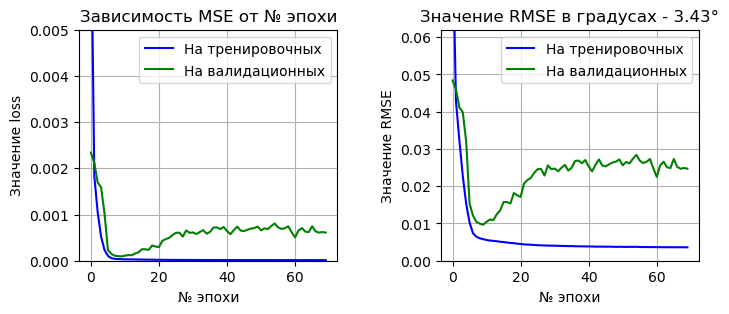

In [72]:
plot_errors_2(loaded_hist_df)

### График прогнозов по нормализованным данным

In [26]:
rmse(normalized_predictions_180, y_test)

0.019266775383484848

In [ ]:
plot_predictions(normalized_predictions_180, y_test, 0, 11000, True)

### Результаты по восстановленным данным

In [28]:
postprocessed_predictions_180 = normalized_predictions_180 * 180

In [ ]:
plot_predictions(postprocessed_predictions_180, y_test*180, 0, 11000)

In [32]:
rmse(postprocessed_predictions_180, y_test*180)

3.4680195715105513